<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/MultiModel_images_ferramenta_GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report
!pip install patool
import patoolib

In [ ]:
# Use this to download files from drive
# !gdown link

In [51]:
!gdown https://drive.google.com/uc?id=1mt8xgtCsp1866_JtVUXSBKV5N-vjwV7Z

Downloading...
From: https://drive.google.com/uc?id=1mt8xgtCsp1866_JtVUXSBKV5N-vjwV7Z
To: /content/multi_model-images-val.rar
100% 953M/953M [00:07<00:00, 120MB/s]


# Extract Images

In [52]:
path = "/content/multi_model-images-val.rar"

In [53]:
patoolib.extract_archive(path, outdir="/content/Data/" )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
patool: Extracting /content/multi_model-images-val.rar ...
patool: running /usr/bin/unrar x -- /content/multi_model-images-val.rar
patool:     with cwd='/content/Data/'
patool: ... /content/multi_model-images-val.rar extracted to `/content/Data/'.


'/content/Data/'

# Loading and Pre-processing Training Data

In [84]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(10),  # Randomly rotate the image by a maximum of 10 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [85]:
class FragmentaDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    # def __getitem__(self, index):
    #     image, label = self.dataset[index]
    #     return image, label

    def __getitem__(self, index):
        while True:
            try:
                image, label = self.dataset[index]
                return image, label
            except (UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Error loading image at index {index}: {e}")
                index += 1

    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [86]:
data_dir = "/content/Data/multimodel-images-train/"
dataset = FragmentaDataset(data_dir)

In [ ]:
print("Number of samples:", len(dataset))
print("Number of classes:", len(dataset.classes))

Number of samples: 66141
Number of classes: 52


In [ ]:
num_workers = 2
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
class_lengths_dict = dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 52
Total sum: 66141
dict_values([195, 5654, 1041, 150, 404, 533, 3209, 471, 1991, 1936, 422, 106, 345, 2526, 4679, 119, 163, 627, 176, 136, 98, 5792, 858, 1929, 819, 588, 1368, 2111, 2093, 452, 260, 1010, 180, 3606, 222, 459, 726, 444, 430, 987, 620, 1571, 482, 4075, 768, 134, 243, 359, 1144, 487, 331, 6612])


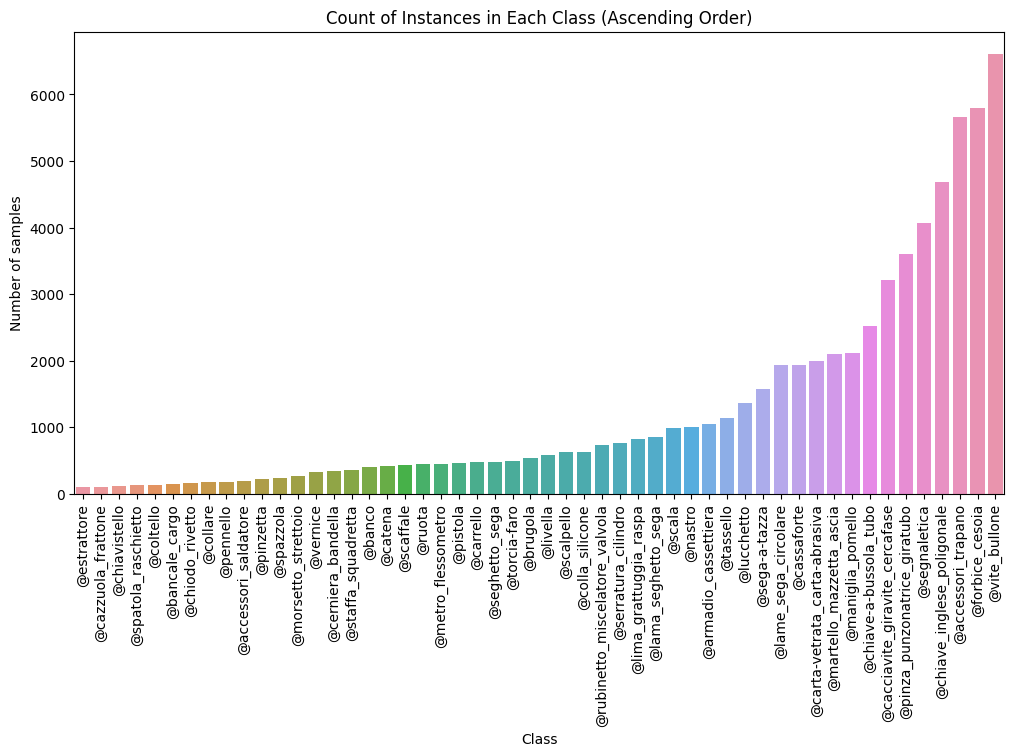

In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Sort the class labels and counts in ascending order
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k])
class_labels_sorted = [class_labels[i] for i in sorted_indices]
class_counts_sorted = [class_counts[i] for i in sorted_indices]

# Create a count plot with sorted data
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels_sorted, y=class_counts_sorted)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class (Ascending Order)')
plt.show()

# EDA

In [87]:
class_length = dataset.class_lengths
class_labels = list(class_length.keys())

In [88]:
from torchvision.transforms import ToPILImage

def plot_sample_images(dataset):


    # Create a grid layout based on the number of classes
    num_classes = len(class_length)
    grid_cols = 4  # Number of columns in the grid
    grid_rows = (num_classes + grid_cols - 1) // grid_cols  # Number of rows in the grid
    plt.figure(figsize=(10, 5 * grid_rows))

    # Create a transform to convert the tensor to PIL Image
    to_pil = ToPILImage()

    # Iterate over each class
    for i, class_label in enumerate(class_labels):
        # Get a random image index from the class
        image_index = np.random.choice(class_length[class_label])

        # Get the image and label from the dataset
        image, label = dataset[image_index]

        # Convert the image tensor to PIL Image
        image = to_pil(image)

        # Plot the image
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(image, interpolation='none')  # Use 'RGB' interpolation
        plt.title(class_label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


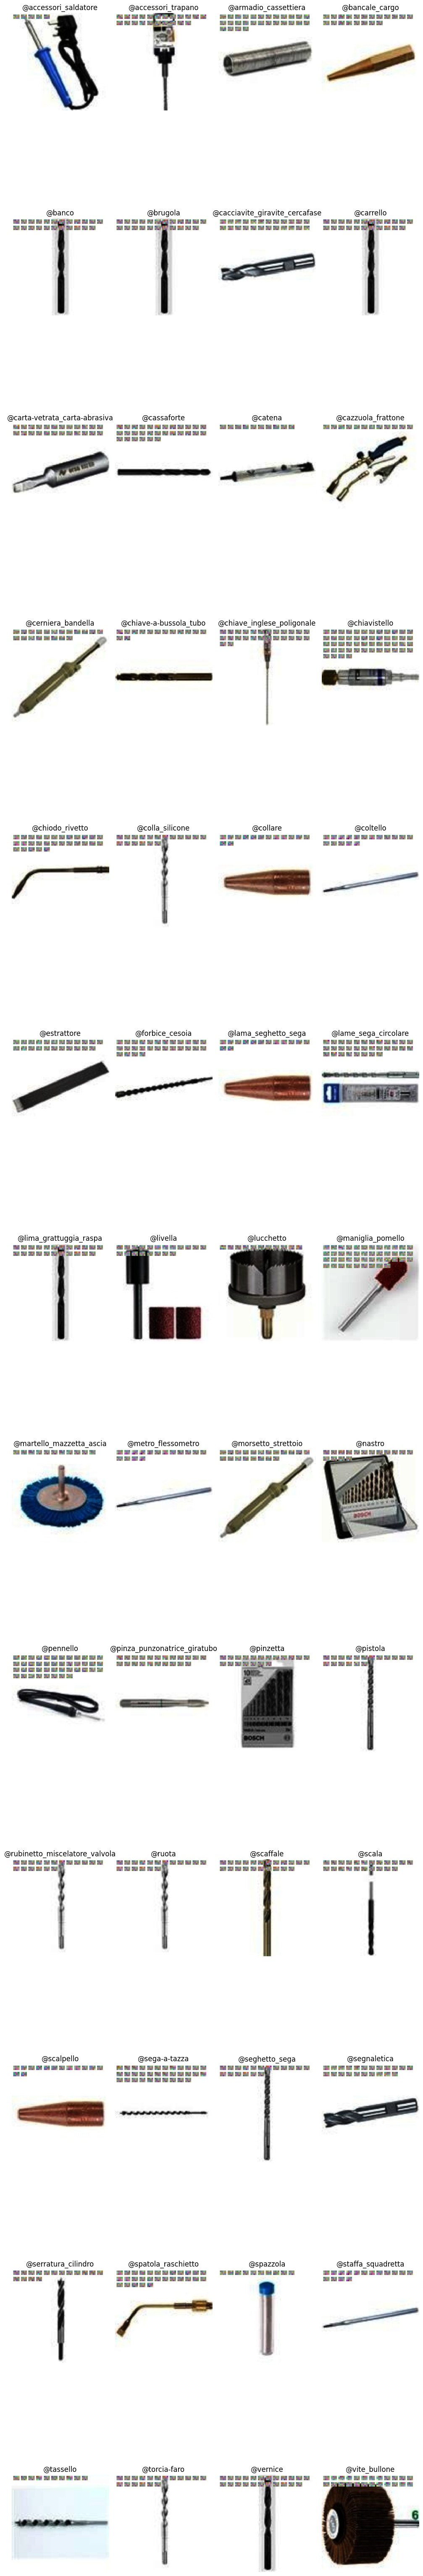

In [89]:
plot_sample_images(dataset)

# Loading and Fine-Tuning GoogleNet

In [ ]:
googlenet = models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 107MB/s]


In [ ]:
num_classes = len(data_loader.dataset.dataset.classes)
googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, num_classes)
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)
print(device)

cuda


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 25

In [ ]:
training_losses = []
googlenet.train()
# Loop over the dataset and train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = googlenet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader.dataset)
    training_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

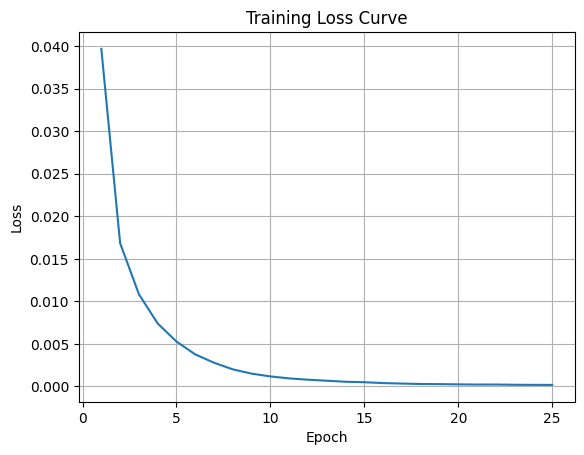

In [49]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Save and Download Model Files

In [48]:
save_dir = "/content/Model/GoogleNet_MultiModel/"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

save_path = os.path.join(save_dir, 'googleNet.pth')  # Specify the complete path to the model file
torch.save(googlenet.state_dict(), save_path)

In [82]:
!zip -r /content/MultiModel_GoogleNet.zip /content/Model

  adding: content/Model/ (stored 0%)
  adding: content/Model/GoogleNet_MultiModel/ (stored 0%)
  adding: content/Model/GoogleNet_MultiModel/googleNet.pth (deflated 7%)


In [83]:
from google.colab import files
files.download("/content/MultiModel_GoogleNet.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Loading and Pre-processing Validation Dataset

In [72]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [73]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.dataset = datasets.ImageFolder(data_dir, transform=val_transform)
        self.data_dir = data_dir
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    # def __getitem__(self, index):
    #     image, label = self.dataset[index]
    #     return image, label

    def __getitem__(self, index):
        while True:
            try:
                image, label = self.dataset[index]
                return image, label
            except (UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Error loading image at index {index}: {e}")
                index += 1

    def __len__(self):
        return len(self.dataset)

In [74]:
valPath = "/content/Data/multimodel-images-val"
val_dataset = ValidationDataset(valPath)

In [75]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 21869
Number of classes: 52


In [76]:
batch_size = 32
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [61]:
class_lengths_dict = val_dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 52
Total sum: 21869
dict_values([59, 1879, 345, 48, 132, 176, 1069, 148, 663, 642, 136, 35, 112, 842, 1555, 36, 51, 206, 59, 43, 33, 1926, 281, 634, 270, 196, 450, 697, 695, 146, 85, 331, 54, 1196, 73, 148, 238, 146, 142, 327, 203, 522, 157, 1352, 254, 37, 80, 116, 379, 159, 106, 2200])


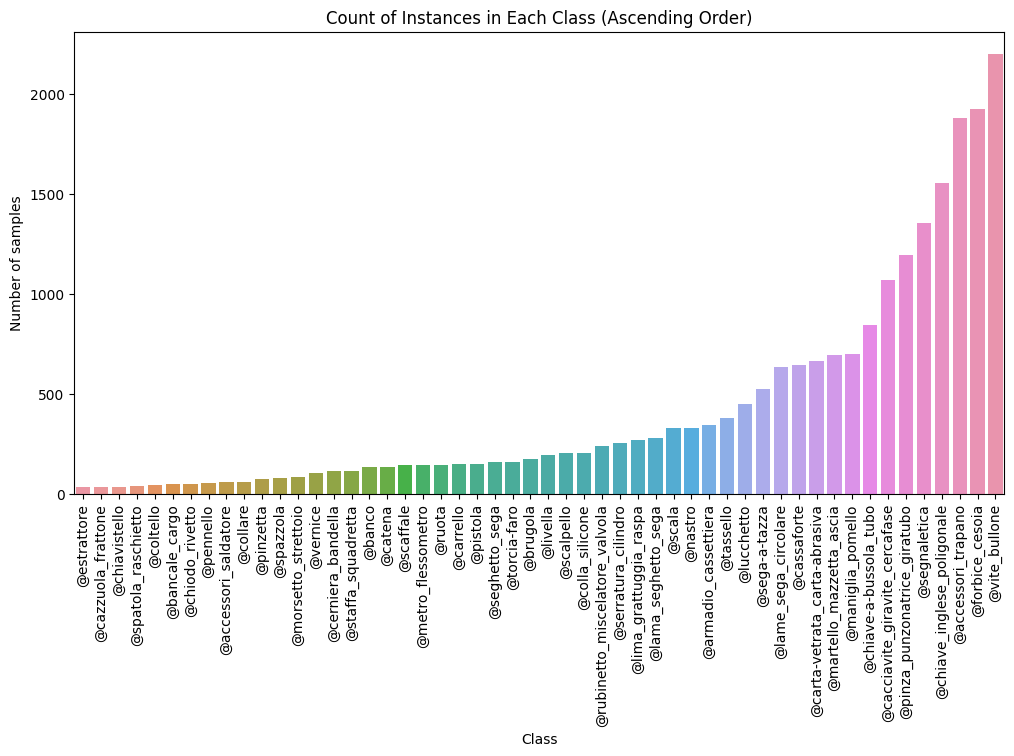

In [62]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Sort the class labels and counts in ascending order
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k])
class_labels_sorted = [class_labels[i] for i in sorted_indices]
class_counts_sorted = [class_counts[i] for i in sorted_indices]

# Create a count plot with sorted data
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels_sorted, y=class_counts_sorted)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class (Ascending Order)')
plt.show()


# Loading and Evaluating Response

In [ ]:
# # Define the model path
# save_dir = ""
# load_path = os.path.join(save_dir, 'model.pth')

# # Create an instance of the ResNet model
# googlenet = models.googlenet(pretrained=False)
# googlenet.fc = nn.Linear(1024, 52)

# # Load the saved model parameters
# googlenet.load_state_dict(torch.load(load_path), strict=False)

# # Set the model to evaluation mode and respective device
# googlenet.eval()
# googlenet.to(device)

In [77]:
predicted_labels = []
true_labels = []

# Evaluation loop
googlenet.eval()
with torch.no_grad():
    for images, labels in validation_data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = googlenet(images)
        _, predicted = torch.max(outputs, 1)

        predicted_labels.extend(predicted.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())


In [78]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.949563308793269
Precision: 0.9495083323641121
Recall: 0.949563308793269
F1-score: 0.9493791274274169


In [79]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.77      0.61      0.68        59
           1       0.97      0.98      0.97      1879
           2       0.97      0.98      0.98       345
           3       1.00      0.98      0.99        48
           4       0.95      0.98      0.97       132
           5       0.90      0.89      0.89       176
           6       0.98      0.99      0.98      1069
           7       0.93      0.94      0.94       148
           8       0.96      0.98      0.97       663
           9       0.98      0.99      0.98       642
          10       0.91      0.93      0.92       136
          11       1.00      0.91      0.96        35
          12       0.87      0.89      0.88       112
          13       0.95      0.97      0.96       842
          14       0.98      0.98      0.98      1555
          15       0.84      0.75      0.79        36
          16       0.88      0.88      0.88        51
          17       0.89    

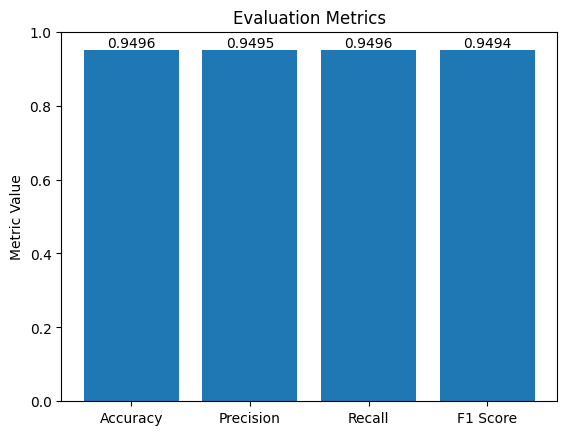

In [80]:
# Define the labels for the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Define the values for each metric
values = [accuracy, precision, recall, f1]

fig, ax = plt.subplots()
bars = ax.bar(metrics, values)
plt.ylim([0, 1])  # Set the y-axis limit to range from 0 to 1
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics')

# Add the metric scores on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()

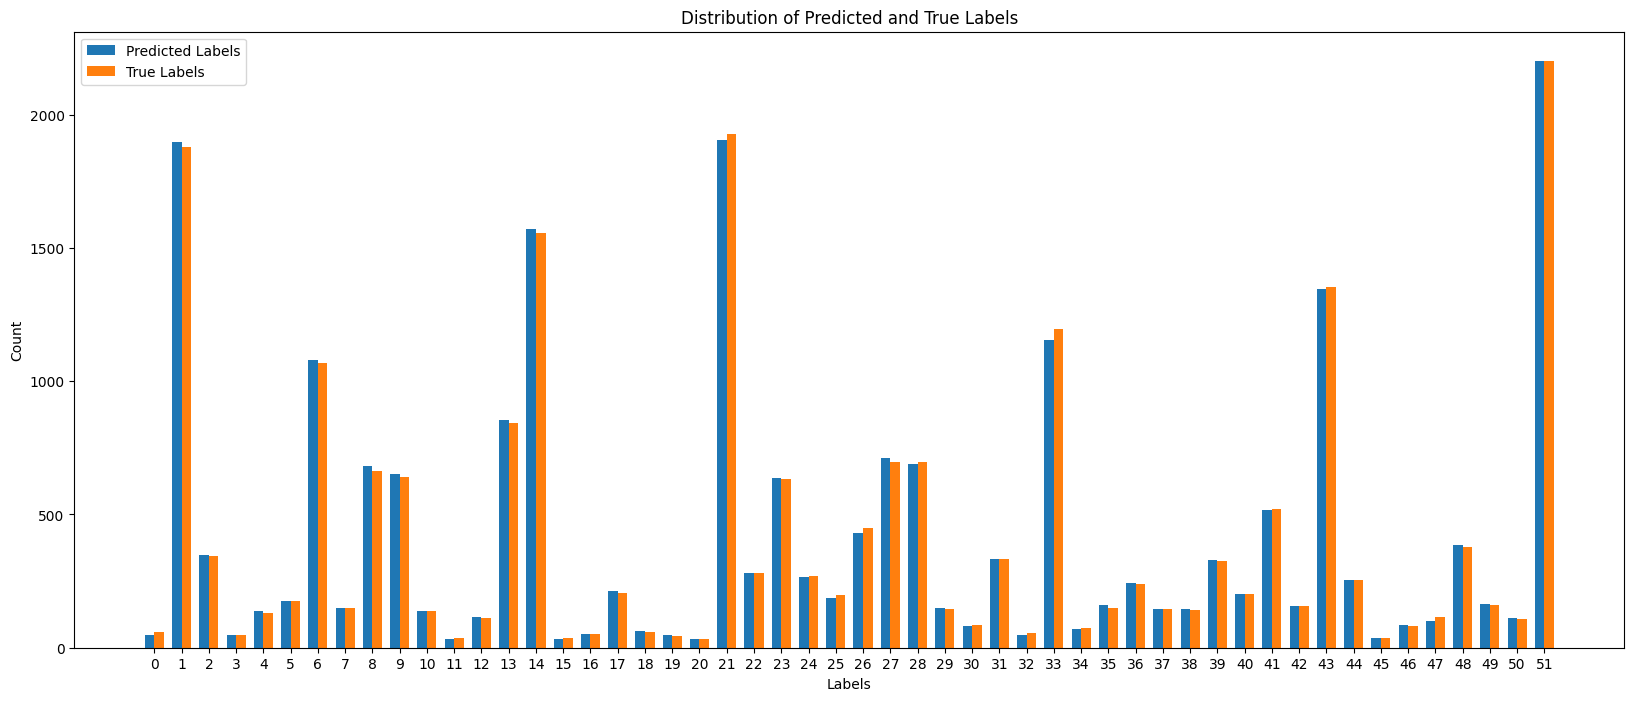

In [81]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_labels)
true_counts = np.bincount(true_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_labels, true_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()